# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import plotly.express as px
import pandas as pd
import json
import plotly.graph_objects as go
from geopy.distance import geodesic
import itertools

# Data Visualization

In [2]:
df =pd.read_csv("/home/kamal/Desktop/2025-AIAA-SciTech /Dataset/Tennessee/Data/Final_Monthly/Full_Tennessee_21_22.csv")

In [3]:
# Identify columns to drop
columns_to_drop = [col for col in df.columns if '_pct' in col]

# Drop the identified columns
df = df.drop(columns=columns_to_drop)

In [4]:
sns.set_theme(style="whitegrid")

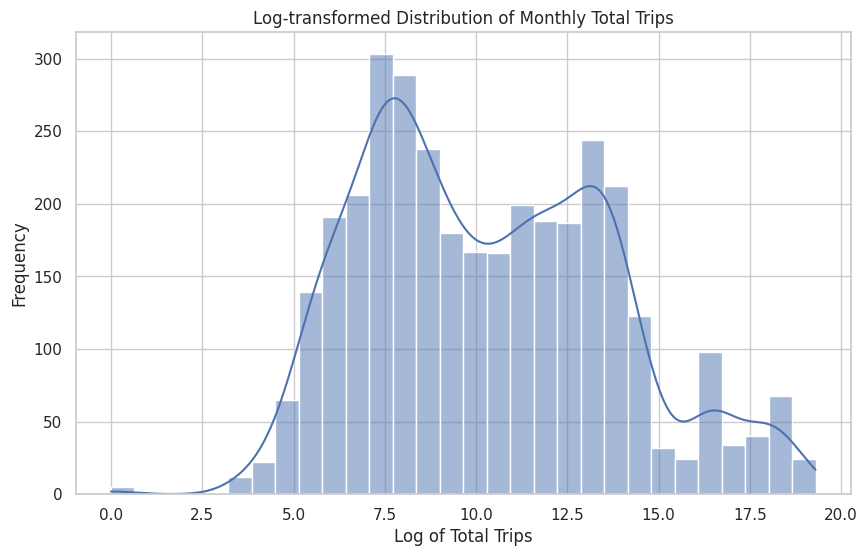

In [5]:
# Log transformation of the 'monthly_total_trips' column to handle skewness

# We add a small constant because log(0) is undefined

# Plotting the log-transformed data
plt.figure(figsize=(10, 6))
sns.histplot(np.log(df['monthly_total_trips'] + 1), kde=True, bins=30)
plt.title('Log-transformed Distribution of Monthly Total Trips')
plt.xlabel('Log of Total Trips')
plt.ylabel('Frequency')
plt.show()


# From the provided plot, we can observe several characteristics:

# The peak of the KDE does not align with the highest bar of the histogram, indicating some asymmetry.
# There is a long right tail with several bins beyond the peak, suggesting that there are values that are much higher than the mode. This is indicative of a distribution with a positive skew.
# The left tail seems to be shorter, and there's a steep drop-off, which means there are not many low-value outliers.
# There appears to be a slight bump or secondary peak on the right side of the distribution.

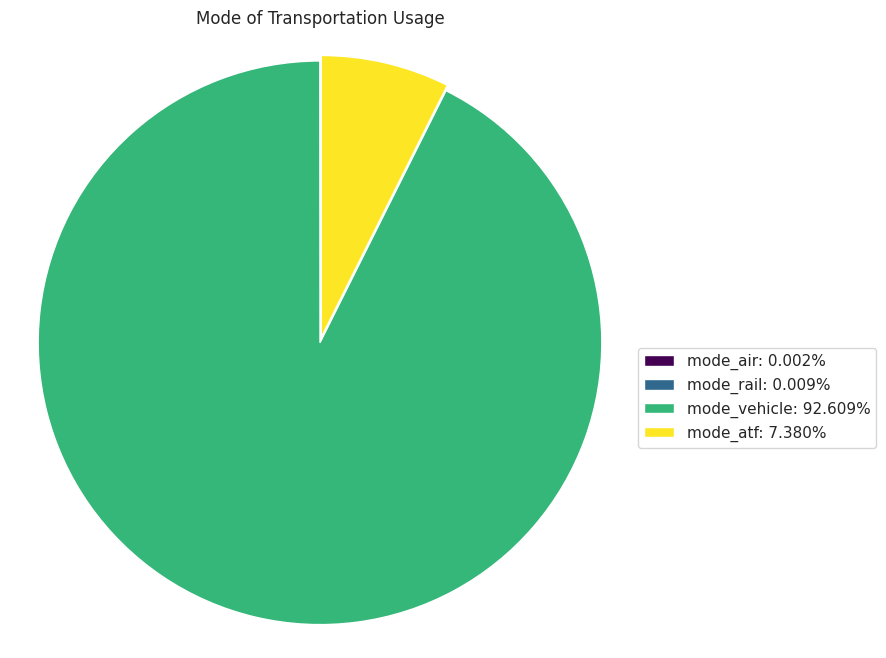

In [6]:
# Modes of transport data aggregation
modes = df[['mode_air', 'mode_rail', 'mode_vehicle', 'mode_atf']].sum()

# Generate a color for each mode using a colormap
colors = plt.cm.viridis(np.linspace(0, 1, len(modes)))

# Pie chart for modes of transportation
plt.figure(figsize=(8, 8))
# Explode all slices a little bit to prevent text overlap
explode = (0.01,) * len(modes)
patches, texts = plt.pie(modes, startangle=90, colors=colors, explode=explode, labels=None)
plt.title('Mode of Transportation Usage')
plt.ylabel('')  # Hide y-label as it's not necessary here

# Create a legend with percentage labels
percentage_labels = [f'{label}: {s/sum(modes)*100:.3f}%' for label, s in zip(modes.index, modes)]
plt.legend(patches, percentage_labels, loc='best', bbox_to_anchor=(1, 0.5))  # Position the legend on the side
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.show()


# The passenger OD data includes air trip, rail trips, vehicle trips, and active transportation/ferries trips as defined below.

# Air trips: Air trips reflect movement from an origin airport to a final destination airport (connecting flights are linked so that the OD data reflects origin airport
#            and final destination airport associated with each OD pair). The data include privately and publicly operated airports; however, most air trips in the data
#            were commercial air trips. All air trips reflect only the airport-to-airport movement by airplane—access trips to an origin airport and egress trips from a
#            destination airport are reported separately as trips in the appropriate ground transportation mode and are not classified as air trips.

# Rail trips: Rail mode means transports carried out through fixed guideway vehicles including Amtrak, commuter rail, and various subways operating on fixed tracks.
#             When the main segment of a trip defined as the longest distance segment among all modes, is made by rail, the trip is considered a rail trip. Unlike air
#             trips where access and egress trips are not included, rail trips include all segments by whatever ground transportation modes were used from the origin of
#             a trip to the final destination. Rail trips include those trips made by Amtrak or regional rail services and are linked trips from the true origin to true
#             destination. For example, for a trip that consists of an initial step of driving 2.1 miles from home to an Amtrak station, then riding the train for 56 miles
#             to another station, and finally taking a taxi for 1.2 miles to the final hotel destination, this entire trip is classified as a rail trip with true origin being
#             the home location, and the true destination being the hotel location.


# Vehicle trips: If the main segment of a trip, defined as the longest distance segment, is made by a vehicle, then such a trip is coded as a vehicle trip. This definition
#               includes vehicle trips to and from airports, but not linked to any rail trips, and includes both private vehicle and public bus trips (transit buses, etc.).
#                For example, a vehicle trip includes someone driving from home to their workplace or to the grocery store. Vehicle trips also include linked trips that
#                consist of someone walking to a bus stop, taking a bus or series of buses (but no rail), then walking to the final trip destination.


# Active Transportation/Ferries trips: Trips by all other modes are combined into the final mode category. As the predominant modes were walk and bike trips in this category,
#                            followed by ferry trips, this final category is labeled “active transportation/ferries.” The name is shortened to “active transp/ferries” in the
#                           tools, and to “atf” as the variable name in the data file. A trip categorized as “active transportation/ferries” represents start and end movements
#                         between true origin and destination locations, and tends most often to be an unlinked trip, such as a walking trip between home and a corner store.



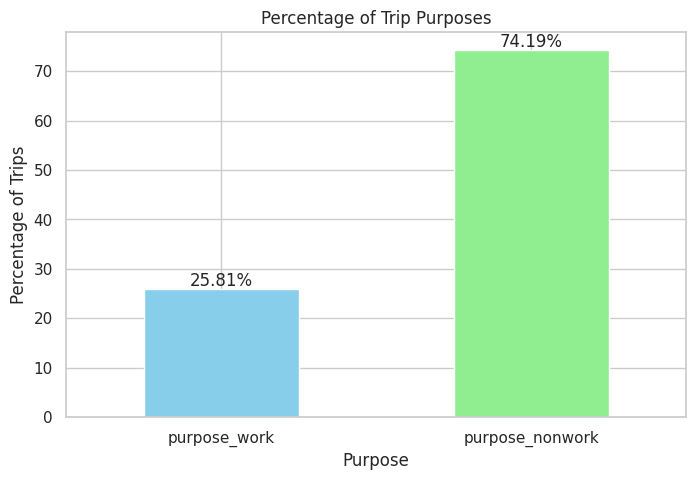

In [7]:
# Aggregating purpose data
purposes = df[['purpose_work', 'purpose_nonwork']].sum()

# Calculating percentages
total_trips = purposes.sum()
purposes_percentage = (purposes / total_trips) * 100

# Bar chart for trip purposes in percentages
plt.figure(figsize=(8, 5))
bars = purposes_percentage.plot.bar(color=['skyblue', 'lightgreen'])

# Adding percentage labels on top of the bars
for bar in bars.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}%', ha='center', va='bottom')

plt.title('Percentage of Trip Purposes')
plt.xlabel('Purpose')
plt.ylabel('Percentage of Trips')
plt.xticks(rotation=0)  # Keep the labels horizontal
plt.show()

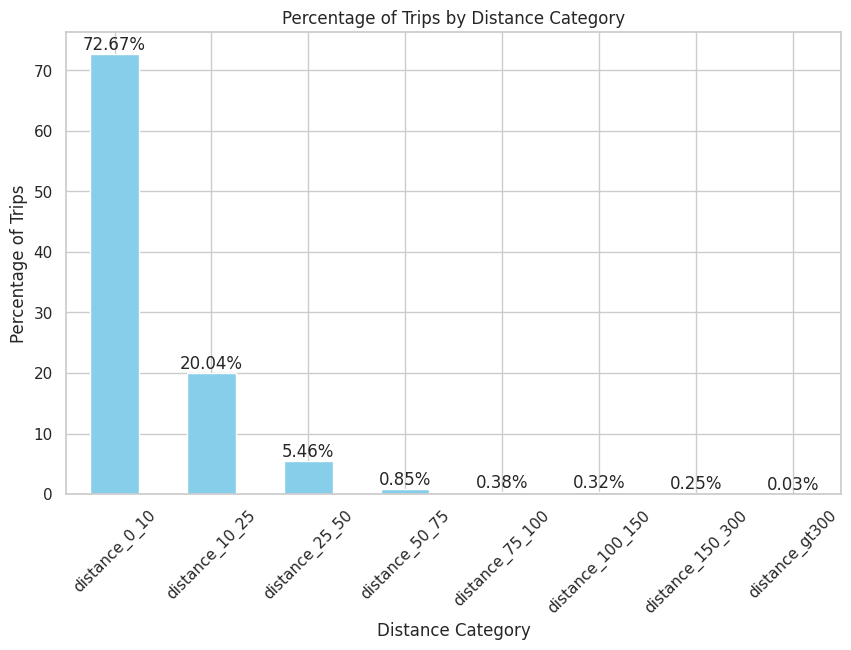

In [8]:
# Sum the number of trips for each distance category
distance_columns = [col for col in df.columns if col.startswith('distance_')]
trip_counts = df[distance_columns].sum()

# Calculate percentages
total_distance_trips = trip_counts.sum()
trip_percentages = (trip_counts / total_distance_trips) * 100

# Plotting the percentage of trips for each distance category
plt.figure(figsize=(10, 6))
bars = trip_percentages.plot(kind='bar', color='skyblue')

# Adding percentage labels on top of the bars
for bar in bars.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}%', ha='center', va='bottom')

plt.title('Percentage of Trips by Distance Category')
plt.xlabel('Distance Category')
plt.ylabel('Percentage of Trips')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

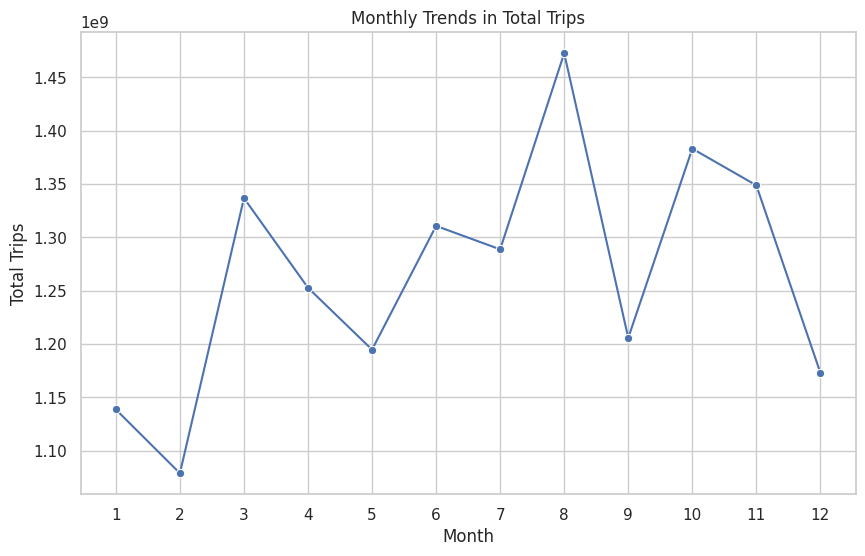

In [9]:
# Group by month and sum trips
monthly_trends = df.groupby('month').agg({'monthly_total_trips': 'sum'})

# Plotting monthly trends
plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_trends, x=monthly_trends.index, y='monthly_total_trips', marker='o')
plt.title('Monthly Trends in Total Trips')
plt.xlabel('Month')
plt.ylabel('Total Trips')
plt.xticks(range(1, 13))  # Assuming data for all months
plt.grid(True)
plt.show()

In [10]:
# Group by 'origin_zone_name' and sum the 'monthly_total_trips' for each group
zone_trip_counts = df.groupby('origin_zone_name')['monthly_total_trips'].sum().reset_index()

# Calculate the total number of trips
total_trips = zone_trip_counts['monthly_total_trips'].sum()

# Add a column for the percentage of total trips
zone_trip_counts['percentage_of_total_trips'] = (zone_trip_counts['monthly_total_trips'] / total_trips) * 100

# Sort the results by the number of trips in descending order (optional)
zone_trip_counts = zone_trip_counts.sort_values('monthly_total_trips', ascending=False)

# Show the distinct values and their corresponding trip counts and percentages
zone_trip_counts

,origin_zone_name,monthly_total_trips,percentage_of_total_trips
9,"Nashville-Davidson-Murfreesboro-Franklin, TN",4473336377,29.458326
7,"Memphis, TN-MS-AR",2138199612,14.080716
6,"Knoxville, TN",2071593107,13.642092
10,TN-NonMSA areas (E),1745776980,11.496490
11,TN-NonMSA areas (W),1631347132,10.742933
0,"Chattanooga, TN-GA",886097860,5.835233
1,"Clarksville, TN-KY",474314885,3.123513
4,"Johnson City, TN",458892072,3.021948
5,"Kingsport-Bristol-Bristol, TN-VA",441728972,2.908924
3,"Jackson, TN",312313202,2.056681


In [11]:
# Group by both 'origin_zone_name' and 'destination_zone_name' and sum the 'monthly_total_trips' for each pair
zone_pairs = df.groupby(['origin_zone_name', 'destination_zone_name'])['monthly_total_trips'].sum().reset_index()

# Remove the pairs where origin and destination zones are the same
zone_pairs = zone_pairs[zone_pairs['origin_zone_name'] != zone_pairs['destination_zone_name']]

# Sort the results by 'monthly_total_trips' in descending order to get the pairs with the highest frequency first
zone_pairs_sorted = zone_pairs.sort_values('monthly_total_trips', ascending=False)

# Calculate the total number of trips
total_trips = zone_pairs_sorted['monthly_total_trips'].sum()

# Add a column for the percentage of total trips
zone_pairs_sorted['percentage_of_total_trips'] = (zone_pairs_sorted['monthly_total_trips'] / total_trips) * 100

# Display the sorted zone pairs along with their total trips and percentage of total trips
zone_pairs_sorted

,origin_zone_name,destination_zone_name,monthly_total_trips,percentage_of_total_trips
126,TN-NonMSA areas (E),"Knoxville, TN",67838085,8.593607
82,"Knoxville, TN",TN-NonMSA areas (E),66810200,8.463396
141,TN-NonMSA areas (W),"Nashville-Davidson-Murfreesboro-Franklin, TN",56457880,7.151983
119,"Nashville-Davidson-Murfreesboro-Franklin, TN",TN-NonMSA areas (W),46567679,5.899110
135,TN-NonMSA areas (W),"Jackson, TN",41450248,5.250843
...,...,...,...,...
63,"Kingsport-Bristol-Bristol, TN-VA","Jackson, TN",6185,0.000784
41,"Jackson, TN","Kingsport-Bristol-Bristol, TN-VA",5951,0.000754
44,"Jackson, TN","Morristown, TN",5116,0.000648
99,"Morristown, TN","Jackson, TN",4984,0.000631


# Regional Air Mobility

In [12]:
# McKinsey defines regional air mobility as the transportation of passengers or cargo across distances of 150 to 800 kilometers, or about 50 to 500 miles,
# in aircraft that seat five to 50 passengers(https://www.mckinsey.com/industries/aerospace-and-defense/our-insights/short-haul-flying-redefined-the-promise-of-regional-air-mobility)

# As per this definition we need to subtract all the trips less than of 50 miles to focus on the regional air mobility. In our case we will subtract the trips less 75 mile
# from the monthly_total_trips

In [13]:
df=pd.read_csv("/home/kamal/Desktop/2025-AIAA-SciTech /Dataset/Tennessee/Data/Final_Monthly/Regional_Tennessee_21_22.csv")

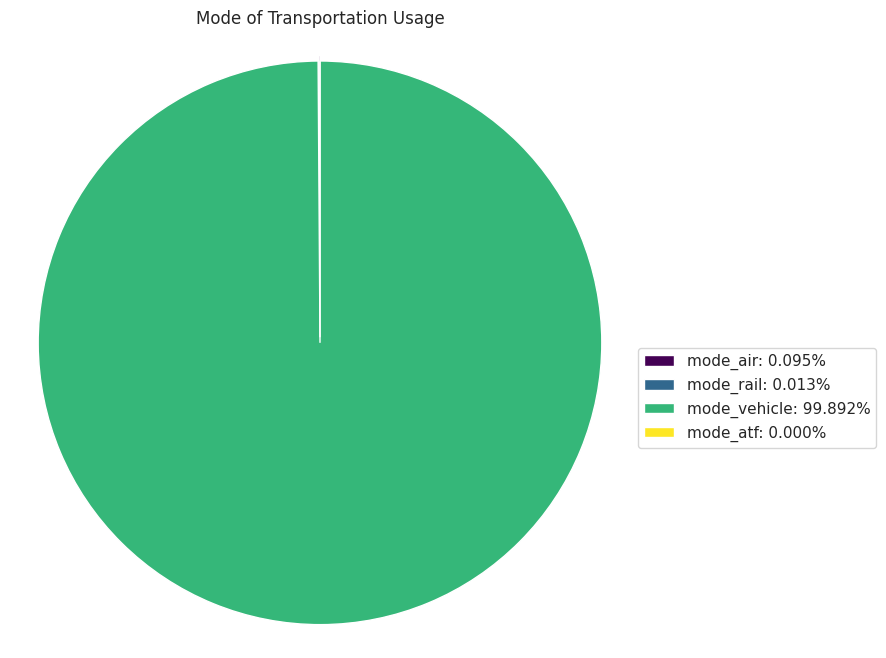

In [14]:
# Modes of transport data aggregation
modes = df[['mode_air', 'mode_rail', 'mode_vehicle', 'mode_atf']].sum()

# Generate a color for each mode using a colormap
colors = plt.cm.viridis(np.linspace(0, 1, len(modes)))

# Pie chart for modes of transportation
plt.figure(figsize=(8, 8))
# Explode all slices a little bit to prevent text overlap
explode = (0.01,) * len(modes)
patches, texts = plt.pie(modes, startangle=90, colors=colors, explode=explode, labels=None)
plt.title('Mode of Transportation Usage')
plt.ylabel('')  # Hide y-label as it's not necessary here

# Create a legend with percentage labels
percentage_labels = [f'{label}: {s/sum(modes)*100:.3f}%' for label, s in zip(modes.index, modes)]
plt.legend(patches, percentage_labels, loc='best', bbox_to_anchor=(1, 0.5))  # Position the legend on the side
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.show()

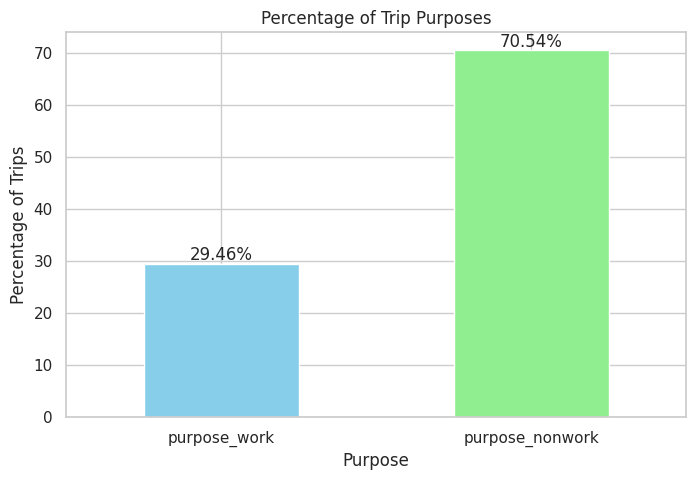

In [15]:
# Aggregating purpose data
purposes = df[['purpose_work', 'purpose_nonwork']].sum()

# Calculating percentages
total_trips = purposes.sum()
purposes_percentage = (purposes / total_trips) * 100

# Bar chart for trip purposes in percentages
plt.figure(figsize=(8, 5))
bars = purposes_percentage.plot.bar(color=['skyblue', 'lightgreen'])

# Adding percentage labels on top of the bars
for bar in bars.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}%', ha='center', va='bottom')

plt.title('Percentage of Trip Purposes')
plt.xlabel('Purpose')
plt.ylabel('Percentage of Trips')
plt.xticks(rotation=0)  # Keep the labels horizontal
plt.show()

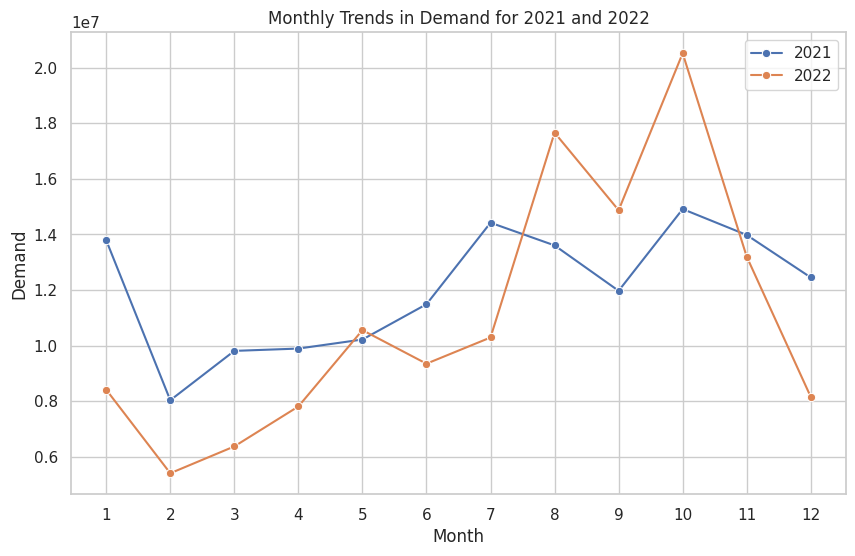

In [16]:
# Filter data for the years 2021 and 2022
df_2021 = df[df['year'] == 2021]
df_2022 = df[df['year'] == 2022]

# Group by month and sum trips for each year
monthly_trends_2021 = df_2021.groupby('month').agg({'Demand': 'sum'}).reset_index()
monthly_trends_2022 = df_2022.groupby('month').agg({'Demand': 'sum'}).reset_index()

# Plotting monthly trends for 2021
plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_trends_2021, x='month', y='Demand', marker='o', label='2021')
sns.lineplot(data=monthly_trends_2022, x='month', y='Demand', marker='o', label='2022')
plt.title('Monthly Trends in Demand for 2021 and 2022')
plt.xlabel('Month')
plt.ylabel('Demand')
plt.xticks(range(1, 13))  # Assuming data for all months
plt.legend()
plt.grid(True)
plt.show()

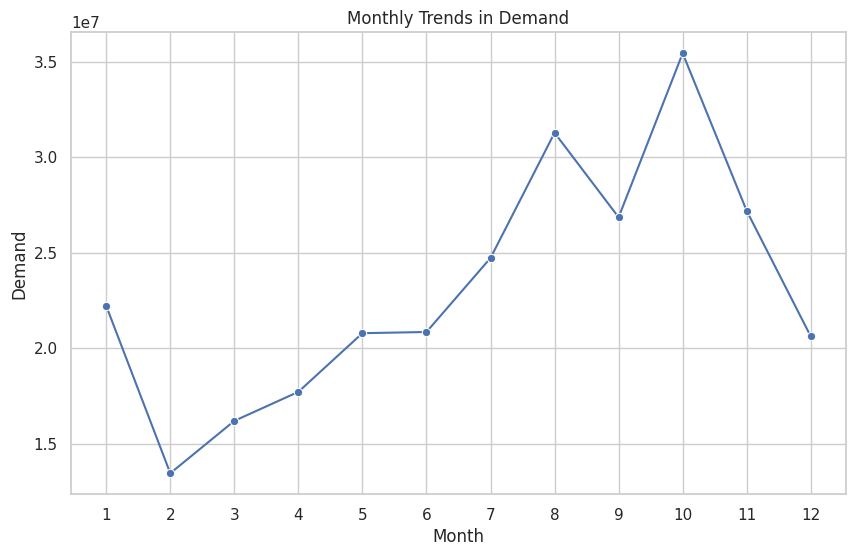

In [17]:
# Group by month and sum trips
monthly_trends = df.groupby('month').agg({'Demand': 'sum'})

# Plotting monthly trends
plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_trends, x=monthly_trends.index, y='Demand', marker='o')
plt.title('Monthly Trends in Demand')
plt.xlabel('Month')
plt.ylabel('Demand')
plt.xticks(range(1, 13))  # Assuming data for all months
plt.grid(True)
plt.show()

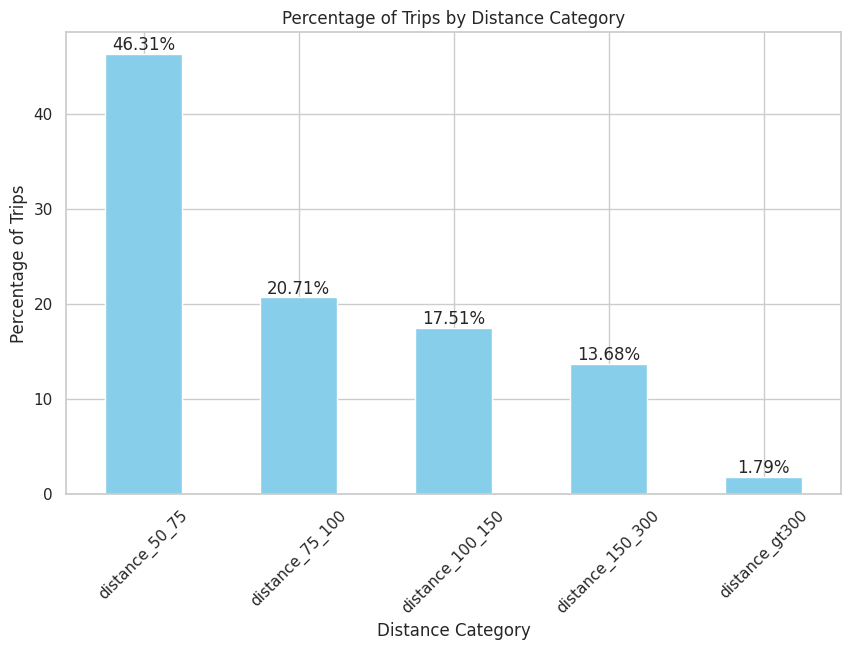

In [18]:
# Sum the number of trips for each distance category
distance_columns = [col for col in df.columns if col.startswith('distance_')]
trip_counts = df[distance_columns].sum()

# Calculate percentages
total_distance_trips = trip_counts.sum()
trip_percentages = (trip_counts / total_distance_trips) * 100

# Plotting the percentage of trips for each distance category
plt.figure(figsize=(10, 6))
bars = trip_percentages.plot(kind='bar', color='skyblue')

# Adding percentage labels on top of the bars
for bar in bars.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}%', ha='center', va='bottom')

plt.title('Percentage of Trips by Distance Category')
plt.xlabel('Distance Category')
plt.ylabel('Percentage of Trips')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [19]:
# Group by 'origin_zone_name' and sum the 'monthly_total_trips' for each group
zone_trip_counts = df.groupby('origin_zone_name')['Demand'].sum().reset_index()

# Calculate the total number of trips
total_trips = zone_trip_counts['Demand'].sum()

# Add a column for the percentage of total trips
zone_trip_counts['Demand'] = (zone_trip_counts['Demand'] / total_trips) * 100

# Sort the results by the number of trips in descending order (optional)
zone_trip_counts = zone_trip_counts.sort_values('Demand', ascending=False)

# Show the distinct values and their corresponding trip counts and percentages
zone_trip_counts

,origin_zone_name,Demand
9,"Nashville-Davidson-Murfreesboro-Franklin, TN",30.410178
11,TN-NonMSA areas (W),17.021334
10,TN-NonMSA areas (E),16.911292
6,"Knoxville, TN",11.588736
7,"Memphis, TN-MS-AR",5.135721
0,"Chattanooga, TN-GA",4.525680
1,"Clarksville, TN-KY",4.187857
3,"Jackson, TN",3.250984
8,"Morristown, TN",2.218515
5,"Kingsport-Bristol-Bristol, TN-VA",1.813895


In [20]:
# Group by both 'origin_zone_name' and 'destination_zone_name' and sum the 'monthly_total_trips' for each pair
zone_pairs = df.groupby(['origin_zone_name', 'destination_zone_name'])['Demand'].sum().reset_index()

# Remove the pairs where origin and destination zones are the same
zone_pairs = zone_pairs[zone_pairs['origin_zone_name'] != zone_pairs['destination_zone_name']]

# Sort the results by 'monthly_total_trips' in descending order to get the pairs with the highest frequency first
zone_pairs_sorted = zone_pairs.sort_values('Demand', ascending=False)

# Calculate the total number of trips
total_trips = zone_pairs_sorted['Demand'].sum()

# Add a column for the percentage of total trips
zone_pairs_sorted['percentage_of_total_trips'] = (zone_pairs_sorted['Demand'] / total_trips) * 100

# Display the sorted zone pairs along with their total trips and percentage of total trips
zone_pairs_sorted

,origin_zone_name,destination_zone_name,Demand,percentage_of_total_trips
141,TN-NonMSA areas (W),"Nashville-Davidson-Murfreesboro-Franklin, TN",17604685,8.354697
119,"Nashville-Davidson-Murfreesboro-Franklin, TN",TN-NonMSA areas (W),15608778,7.407495
126,TN-NonMSA areas (E),"Knoxville, TN",12556569,5.959001
129,TN-NonMSA areas (E),"Nashville-Davidson-Murfreesboro-Franklin, TN",12385405,5.877771
82,"Knoxville, TN",TN-NonMSA areas (E),11832719,5.615481
...,...,...,...,...
63,"Kingsport-Bristol-Bristol, TN-VA","Jackson, TN",6185,0.002935
41,"Jackson, TN","Kingsport-Bristol-Bristol, TN-VA",5951,0.002824
44,"Jackson, TN","Morristown, TN",5116,0.002428
99,"Morristown, TN","Jackson, TN",4984,0.002365


In [21]:
pd.pivot_table(df, values='Demand', index='origin_zone_name', columns='destination_zone_name', aggfunc='sum')

destination_zone_name,"Chattanooga, TN-GA","Clarksville, TN-KY","Cleveland, TN","Jackson, TN","Johnson City, TN","Kingsport-Bristol-Bristol, TN-VA","Knoxville, TN","Memphis, TN-MS-AR","Morristown, TN","Nashville-Davidson-Murfreesboro-Franklin, TN",TN-NonMSA areas (E),TN-NonMSA areas (W)
origin_zone_name,,,,,,,,,,,,
"Chattanooga, TN-GA",473223,84046,356168,40677,88411,65937,2446936,115026,98790,3897776,3775585,1105505
"Clarksville, TN-KY",104626,67948,16606,96850,15669,11210,189172,125396,17868,9647295,306370,1012410
"Cleveland, TN",386772,17240,52722,14231,24597,22697,1368020,25409,58259,544848,931768,161423
"Jackson, TN",38274,70956,11308,107872,4682,5951,56010,3007988,5116,955534,99729,4650388
"Johnson City, TN",82505,20242,29451,6637,81810,253997,1279799,25762,716084,533851,1452047,49762
"Kingsport-Bristol-Bristol, TN-VA",71201,9565,27312,6185,279109,547975,1311529,21162,642490,497958,1567517,47275
"Knoxville, TN",2308728,178708,1373445,64868,1198835,1137835,5277237,274822,2882427,5065549,11832719,536218
"Memphis, TN-MS-AR",122975,124734,25146,3159607,25297,21609,278052,1870791,24291,2874757,281258,5430987
"Morristown, TN",92924,16189,55357,4984,575173,542415,3098327,18919,37185,487120,1174752,47798


In [22]:
df_airports = pd.read_csv('/home/kamal/Desktop/2025-AIAA-SciTech /Dataset/airports_new.csv')

In [23]:
# Select airports in Tennessee and create a copy to avoid SettingWithCopyWarning
tn_airports = df_airports[df_airports['state'] == 'TN'].copy()

# Rename columns to match the names used in your plotting code
tn_airports.rename(columns={
    'lat': 'LATITUDE',
    'long': 'LONGITUDE',  # Corrected column name with stripped spaces
    'iata': 'IATA'
}, inplace=True)


In [24]:
# Defining the Centroid of the MSAs
data = {
    'LATITUDE':   [35.049361,  36.69571,   35.138117,  35.753215,  36.265822,  36.604161,  36.014791,  35.024419,  36.168802,  36.118182, 35.7663, 35.8167 ],
    'LONGITUDE': [-85.361158, -87.624307, -84.655079, -88.882692, -82.332693, -82.440145, -84.206701, -89.871971, -83.422614, -86.64412, -84.9812,  -88.1924],
    'Origin': [
        'Chattanooga, TN-GA', 'Clarksville, TN-KY', 'Cleveland, TN', 'Jackson, TN', 'Johnson City, TN', 'Kingsport-Bristol-Bristol, TN-VA',
        'Knoxville, TN', 'Memphis, TN-MS-AR', 'Morristown, TN', 'Nashville-Davidson-Murfreesboro-Franklin, TN','TN-NonMSA areas (E)', 'TN-NonMSA areas (W)'],
    'CBSA': ['16860', '17300', '17420', '27180', '27740', '28700', '28940', '32820', '34100', '34980','RTN1','RTN3']
}
df_TN = pd.DataFrame(data)

In [25]:
# Function to find the nearest airport
def find_nearest_airport(row, airports):
    origin_coords = (row['LATITUDE'], row['LONGITUDE'])
    distances = airports.apply(
        lambda airport: geodesic(origin_coords, (airport['LATITUDE'], airport['LONGITUDE'])).miles, axis=1
    )
    nearest_airport_index = distances.idxmin()
    return airports.loc[nearest_airport_index, 'IATA'], distances.min()

# Apply the function to each row in df_TN
df_TN[['Nearest_Airport', 'Distance_to_Airport']] = df_TN.apply(
    find_nearest_airport, airports=tn_airports, axis=1, result_type='expand'
)

# Get the list of nearest airports
nearest_airports = df_TN['Nearest_Airport'].unique()

# Filter tn_airports to only include the nearest airports
tn_airports = tn_airports[tn_airports['IATA'].isin(nearest_airports)]


In [26]:
# Load the data from the text file, assuming it's tab-separated
df = pd.read_csv('/home/kamal/Desktop/2025-AIAA-SciTech /Dataset/2021_Gaz_cbsa.txt', sep='\t', engine='python')

In [27]:
# Filter rows where 'Name' contains 'TN'
tennessee_areas = df[df['NAME'].str.contains('TN')]

In [28]:
# Strip any leading/trailing spaces in column names
tennessee_areas.columns = tennessee_areas.columns.str.strip()

# Filter rows where 'NAME' contains 'TN'
df_TN1 = tennessee_areas[tennessee_areas['NAME'].str.contains('TN')].copy()

# Rename columns to match the names used in your plotting code
df_TN1.rename(columns={
    'INTPTLAT': 'LATITUDE',
    'INTPTLONG': 'LONGITUDE',  # Corrected column name with stripped spaces
    'NAME': 'Origin',
    'GEOID': 'CBSA'
}, inplace=True)

df_TN1['hover_text'] = df_TN1.apply(lambda x: f"{x['Origin']}<br>Lat: {x['LATITUDE']:.4f}<br>Lon: {x['LONGITUDE']:.4f}<br>CBSA: {x['CBSA']}", axis=1)

# # Display the filtered DataFrame
df_TN2 = df_TN1[['LATITUDE', 'LONGITUDE', 'Origin', 'CBSA', 'hover_text']]


In [29]:
# # Load the counties GeoJSON file for Tennessee
with open('/home/kamal/Desktop/2025-AIAA-SciTech /Dataset/Tennessee/Data/MSA.json') as file:
    tn_counties_geojson = json.load(file)

# Add a new column for hover text which includes latitude, longitude, and CBSA code
df_TN['hover_text'] = df_TN.apply(lambda x: f"{x['Origin']}<br>Lat: {x['LATITUDE']:.4f}<br>Lon: {x['LONGITUDE']:.4f}<br>CBSA: {x['CBSA']}", axis=1)


# Create a color map for CBSA codes
cbsa_color_map = {
    '16860': 'red', '17300': 'deeppink', '17420': 'blue', '27180': 'green', '27740': 'orange',
    '28700': 'purple', '28940': 'brown', '32820': 'mediumpurple', '34100': 'tomato', '34980': 'black', 'RTN1': 'deepskyblue', 'RTN3':'darkkhaki'
}

# CBSA codes stand for "Core-Based Statistical Area" codes.
#These codes are numerical designations used by the U.S. Office of Management and Budget to identify geographical areas for collecting, tabulating, and publishing federal statistics.

fig = px.scatter_mapbox(df_TN, lat="LATITUDE", lon="LONGITUDE", hover_name="Origin", hover_data=["Origin", "CBSA"], zoom=6, height=500, center={"lat": 35.5175, "lon": -86.5804}, mapbox_style="open-street-map")

# Initialize a set to track CBSA codes that have been plotted
plotted_cbsas = set()

# Adding county boundaries from the GeoJSON list
for feature in tn_counties_geojson:
    if feature['geometry']['type'] == 'Polygon':
        for coords in feature['geometry']['coordinates']:
            latitudes = [point[1] for point in coords]
            longitudes = [point[0] for point in coords]
            cbsa_code = feature['properties'].get('CBSAFP2', 'Unknown')  # Get CBSA code, default to 'Unknown'
            color = cbsa_color_map.get(cbsa_code, 'black')  # Default to black if CBSA code not found

            # Check if CBSA code is being plotted for the first time
            if cbsa_code not in plotted_cbsas:
                trace_name = cbsa_code  # Use CBSA code as the trace name
                show_legend = True  # Allow this trace to appear in the legend
                plotted_cbsas.add(cbsa_code)  # Mark this CBSA code as plotted
            else:
                trace_name = ""  # No name for additional traces of the same CBSA
                show_legend = False  # Do not show in legend

            fig.add_trace(
                go.Scattermapbox(
                    lat=latitudes,
                    lon=longitudes,
                    mode='lines',
                    line=dict(width=1, color='white'),  # Set boundary line color to black
                    fill='toself',
                    fillcolor=color,
                    name=trace_name,
                    showlegend=show_legend
                )
            )

    elif feature['geometry']['type'] == 'MultiPolygon':
        # This handles multiple polygons defining one county
        for poly in feature['geometry']['coordinates']:
            for coords in poly:
                latitudes = [point[1] for point in coords]
                longitudes = [point[0] for point in coords]
                cbsa_code = feature['properties'].get('CBSAFP2', 'Unknown')  # Get CBSA code, default to 'Unknown'
                color = cbsa_color_map.get(cbsa_code, 'black')  # Default to black if CBSA code not found

                # Check if CBSA code is being plotted for the first time
                if cbsa_code not in plotted_cbsas:
                    trace_name = cbsa_code  # Use CBSA code as the trace name
                    show_legend = True  # Allow this trace to appear in the legend
                    plotted_cbsas.add(cbsa_code)  # Mark this CBSA code as plotted
                else:
                    trace_name = ""  # No name for additional traces of the same CBSA
                    show_legend = False  # Do not show in legend

                fig.add_trace(
                    go.Scattermapbox(
                        lat=latitudes,
                        lon=longitudes,
                        mode='none',
                        fill='toself',
                        fillcolor=color,
                        name=trace_name,
                        showlegend=show_legend
                    )
                )



# Plotting points over the filled areas
fig.add_trace(
    go.Scattermapbox(
        lat=df_TN['LATITUDE'],
        lon=df_TN['LONGITUDE'],
        mode='markers',
        marker=dict(
            size=10,  # Increase size to make more visible
            color='white',  # Bright color to stand out
            opacity=1  # Full opacity for visibility
        ),
        text=df_TN['hover_text'],  # Text to display on hover
        hoverinfo='text',
        showlegend=False
    )
)


# Plotting airports over the filled areas
fig.add_trace(
    go.Scattermapbox(
        lat=tn_airports['LATITUDE'],
        lon=tn_airports['LONGITUDE'],
        mode='markers',
        marker=dict(
            size=10,  # Increase size to make more visible
            color='Yellow',  # Bright color to stand out
            opacity=1  # Full opacity for visibility
            # symbol='airport'
        ),
        # marker_symbol=[{
        #     'icon': "https://upload.wikimedia.org/wikipedia/commons/f/f3/Wikivoyage-icon-airport.svg",
        #     'sizex': 20,
        #     'sizey': 20,
        #     'sizeref': 1,
        #     'opacity': 0.7
        # }] * len(tn_airports),  # Apply custom icon for each airport
        text=tn_airports['IATA'],  # Text to display on hover
        hoverinfo='text',
        showlegend=False
    )
)


# Update layout
fig.update_layout(mapbox_style="open-street-map",
    margin={"r":0, "t":0, "l":0, "b":0},
    showlegend=True
)

fig.show()

# Findind the latitude and longitude of all the locations along with the haversian distance between all OD pairs

In [30]:
# Select rows where 'Origin' column contains the string 'Metro'
metro_df = df_TN1[df_TN2['Origin'].str.contains('Metro', na=False)]

# Select only the specified columns
selected_columns_df = metro_df[['LATITUDE', 'LONGITUDE', 'CBSA']]

# Rename just the 'CBSA' column
renamed_df = selected_columns_df.rename(columns={'CBSA': 'Location'})


airports=tn_airports[['IATA', 'LATITUDE', 'LONGITUDE']]
airports_renamed= airports.rename(columns={'IATA': 'Location'})

# Concatenate the DataFrames
merged_df = pd.concat([renamed_df, airports_renamed], ignore_index=True)


#merged_df.to_csv("/content/drive/MyDrive/NASA-Project/Dataset/Tennessee/Location/location.csv", index=False)

# Manually RTN1 and RTN3 are added


In [31]:
df =pd.read_csv("/home/kamal/Desktop/2025-AIAA-SciTech /Dataset/Tennessee/Location/location_more_airports.csv")

In [32]:
# Function to calculate Haversine distance
def haversine(lat1, lon1, lat2, lon2):
    R = 3959.0  # Earth radius in miles

    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c
    return distance


# Generate all possible origin-destination pairs (including both directions)
pairs = list(itertools.permutations(df.index, 2))

# Calculate Haversine distances for each pair
distances = []
for (i, j) in pairs:
    lat1, lon1 = df.loc[i, ['LATITUDE', 'LONGITUDE']]
    lat2, lon2 = df.loc[j, ['LATITUDE', 'LONGITUDE']]
    distance = haversine(lat1, lon1, lat2, lon2)
    distances.append((df.loc[i, 'Location'], df.loc[j, 'Location'], distance))

# Create a new dataframe for origin-destination pairs with distances
df_distances = pd.DataFrame(distances, columns=['Origin', 'Destination', 'Distance_H'])


In [33]:
df=pd.read_csv("/home/kamal/Desktop/2025-AIAA-SciTech /Dataset/Tennessee/DistanceAndTimeRTN_more_airports.csv")

In [34]:
# Rename RTN2 to RTN3 in Origin and Destination columns
df['Origin'] = df['Origin'].replace('RTN2', 'RTN3')
df['Destination'] = df['Destination'].replace('RTN2', 'RTN3')

In [35]:
# Merge the dataframes on Origin and Destination pairs using a left join
combined_df = pd.merge(df_distances, df, on=['Origin', 'Destination'], how='left')

In [36]:
#combined_df.to_csv("/content/drive/MyDrive/NASA-Project/Dataset/Tennessee/FinalDistanceAndTimeRTN_more_airports.csv", index=False)